# import required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Setup Environment

In [ ]:
input_shape_2D = (224,224)
input_shape_3D = (224,224,3)
seed = 1
batch_size = 32
epochs = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Load Image data

In [ ]:

# Load dataset from directory (assuming images are stored in folders for each class)
data = tf.keras.utils.image_dataset_from_directory(
    directory="/content/drive/MyDrive/rice_leaf_diseases",  # Adjust path as necessary
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    image_size=(224, 224),
    seed=1
)

Found 120 files belonging to 3 classes.


In [ ]:
# print class names

class_names = data.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# visualise Images

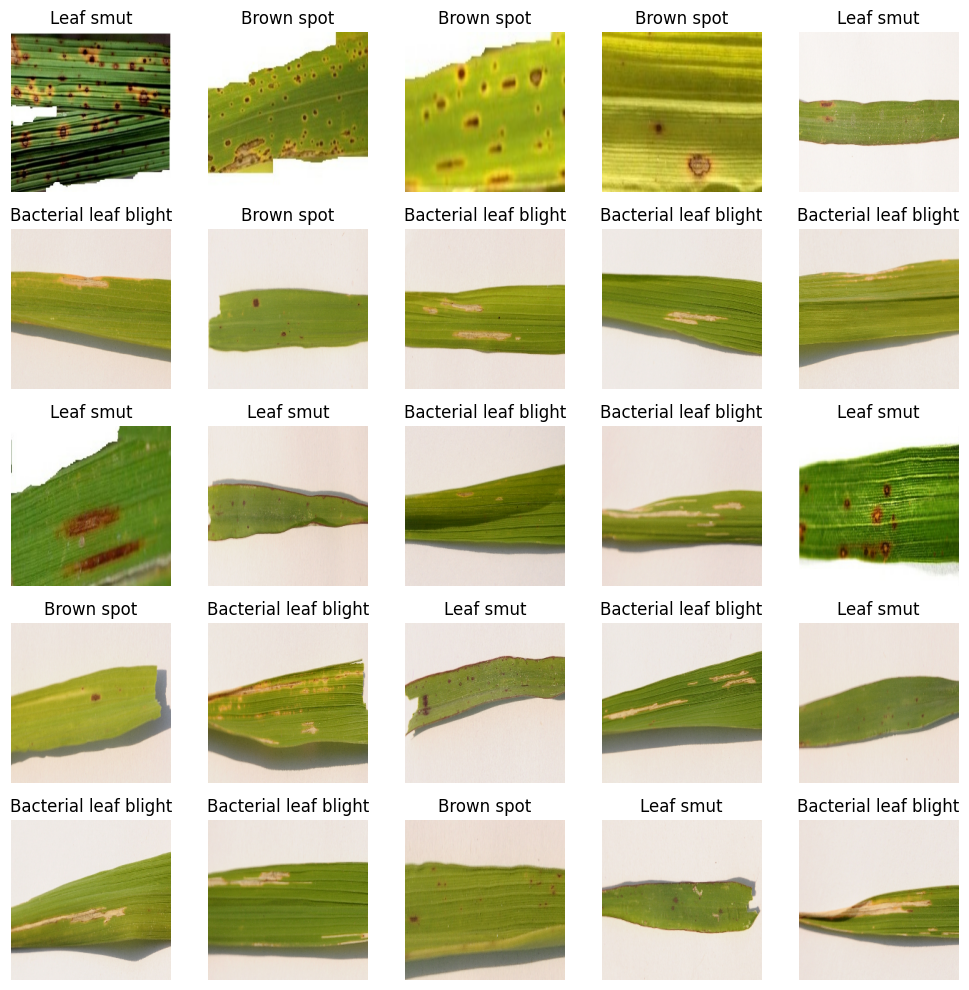

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()

# Data Preprocessing

In [ ]:
X = []
y = []

for images, labels in data:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Normalize images
X = X.astype('float32') / 255

# Use train_test_split to randomly split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, len(class_names))
y_test = to_categorical(y_test, len(class_names))



In [ ]:
# Define CNN Model
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=16, kernel_size=3, padding='same', strides=1, activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))

model_cnn.add(Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))

model_cnn.add(Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))

model_cnn.add(Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(filters=256, kernel_size=3, padding='same', strides=1, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.3))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(250, activation='relu'))
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(len(class_names), activation='softmax'))
model_cnn.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 74, 74, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │         256,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          25,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 674,261 (2.57 MB)

 Trainable params: 674,261 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the CNN model
model_cnn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define ModelCheckpoint callback
check_pointer = ModelCheckpoint(
    filepath='cnn_model.best.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto',
    save_weights_only=True
)


In [ ]:
# Train CNN model
history_cnn = model_cnn.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[check_pointer],
    verbose=1
)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 738ms/step - accuracy: 0.3294 - loss: 1.1042 - val_accuracy: 0.2500 - val_loss: 1.1409
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2956 - loss: 1.0937 - val_accuracy: 0.2500 - val_loss: 1.1475
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3242 - loss: 1.0974 - val_accuracy: 0.2500 - val_loss: 1.1190
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3203 - loss: 1.0892 - val_accuracy: 0.2500 - val_loss: 1.1199
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3516 - loss: 1.1052 - val_accuracy: 0.2500 - val_loss: 1.1253
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3854 - loss: 1.0800 - val_accuracy: 0.2500 - val_loss: 1.1462
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3659 - loss: 1.0936 - val_accuracy: 0.2500 - val_loss: 1.1417
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4688 - loss: 1.0629 - val_accuracy: 0.3333 - val_los

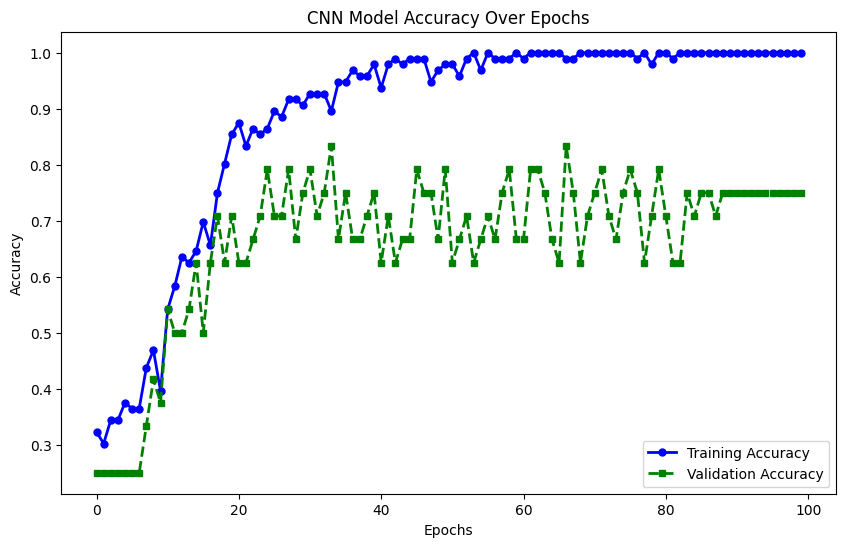

In [ ]:
# Visualize training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2, marker='o', markersize=5)
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='green', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.title("CNN Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

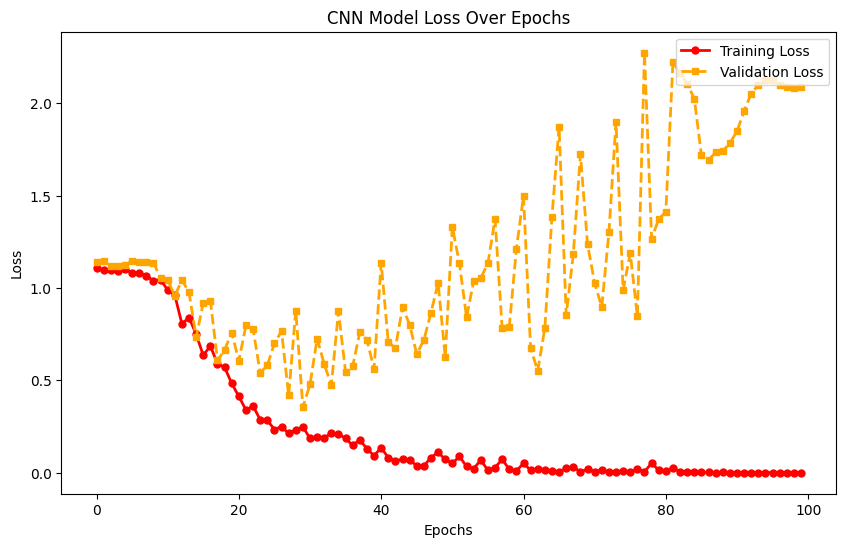

In [ ]:
# Visualize training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['loss'], label='Training Loss', color='red', linewidth=2, marker='o', markersize=5)
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color='orange', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.title("CNN Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Predictions and Evaluation
y_pred_cnn = model_cnn.predict(X_test)
predicted_classes_cnn = np.argmax(y_pred_cnn, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


In [ ]:
# Classification Report
print("CNN Classification Report:\n", classification_report(np.argmax(y_test, axis=1), predicted_classes_cnn, target_names=class_names))

CNN Classification Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       0.86      1.00      0.92         6
           Brown spot       0.86      0.55      0.67        11
            Leaf smut       0.60      0.86      0.71         7

             accuracy                           0.75        24
            macro avg       0.77      0.80      0.77        24
         weighted avg       0.78      0.75      0.74        24



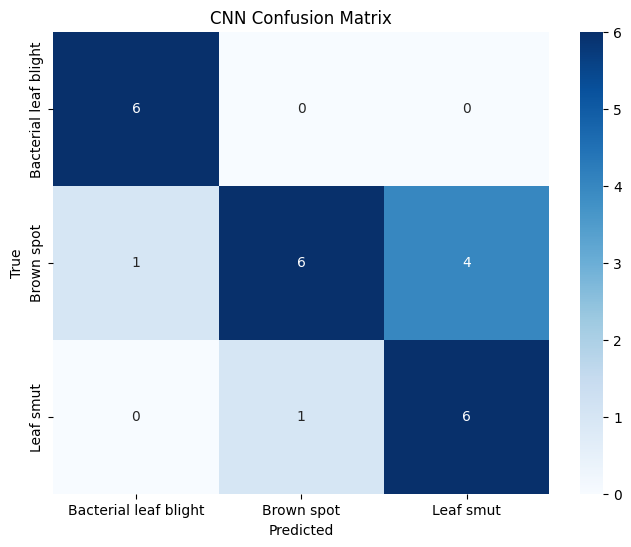

In [ ]:
# Confusion Matrix
cm_cnn = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet

# Load pre-trained MobileNet model (without top classification layers)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # First dense layer
x = BatchNormalization()(x)  # Add Batch Normalization after the dense layer
x = Dropout(0.5)(x)  # Dropout layer
x = Dense(512, activation='relu')(x)  # Additional dense layer to increase capacity
x = Dropout(0.5)(x)  # Another dropout to avoid overfitting
x = Dense(len(class_names), activation='softmax')(x)  # Final output layer

# Define the MobileNet model
model_mobilenet = Model(inputs=base_model.input, outputs=x)

# Summary of the updated model
model_mobilenet.summary()



17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,808,899 (18.34 MB)

 Trainable params: 1,577,987 (6.02 MB)

 Non-trainable params: 3,230,912 (12.32 MB)

In [ ]:
# Compile MobileNet model
model_mobilenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train MobileNet model
history_mobilenet = model_mobilenet.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[check_pointer],
    verbose=1
)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4453 - loss: 2.3353 - val_accuracy: 0.5000 - val_loss: 1.3615
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8698 - loss: 0.4408 - val_accuracy: 0.5833 - val_loss: 1.0685
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9323 - loss: 0.2033 - val_accuracy: 0.7083 - val_loss: 0.8484
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9857 - loss: 0.0843 - val_accuracy: 0.6667 - val_loss: 0.8113
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9570 - loss: 0.1190 - val_accuracy: 0.7083 - val_loss: 0.8419
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9388 - loss: 0.0980 - val_accuracy: 0.6667 - val_loss: 0.8927
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9779 - loss: 0.0358 - val_accuracy: 0.6667 - val_loss: 0.9494
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9557 - loss: 0.0672 - val_accuracy: 0.6667 - val_loss: 

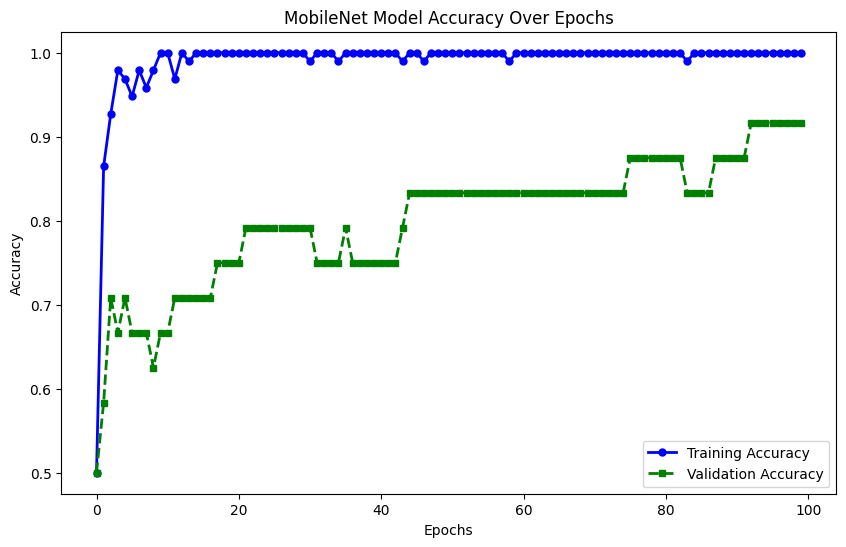

In [ ]:
# Visualize training and validation accuracy for MobileNet
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2, marker='o', markersize=5)
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy', color='green', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.title("MobileNet Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

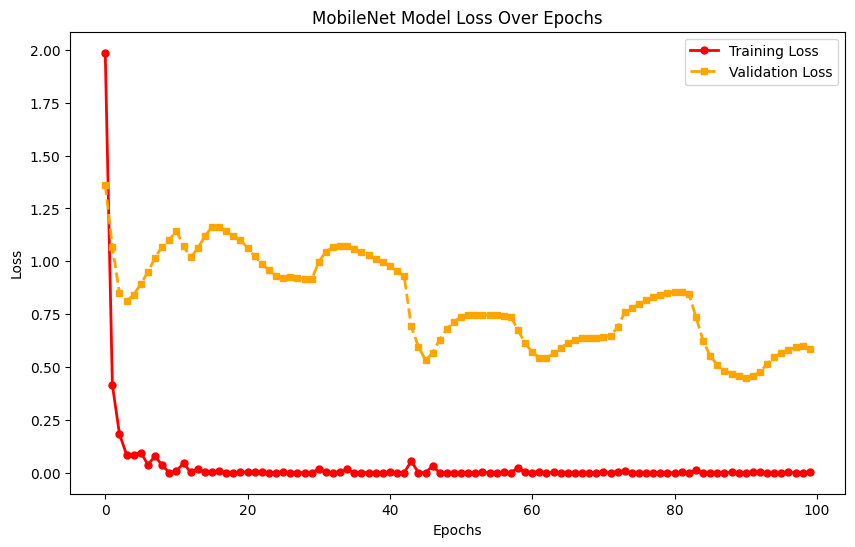

In [ ]:
# Visualize training and validation loss for MobileNet
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenet.history['loss'], label='Training Loss', color='red', linewidth=2, marker='o', markersize=5)
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss', color='orange', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.title("MobileNet Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Predictions and Evaluation for MobileNet
y_pred_mobilenet = model_mobilenet.predict(X_test)
predicted_classes_mobilenet = np.argmax(y_pred_mobilenet, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Classification Report for MobileNet
print("MobileNet Classification Report:\n", classification_report(np.argmax(y_test, axis=1), predicted_classes_mobilenet, target_names=class_names))

MobileNet Classification Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       0.91      0.91      0.91        11
            Leaf smut       0.86      0.86      0.86         7

             accuracy                           0.92        24
            macro avg       0.92      0.92      0.92        24
         weighted avg       0.92      0.92      0.92        24



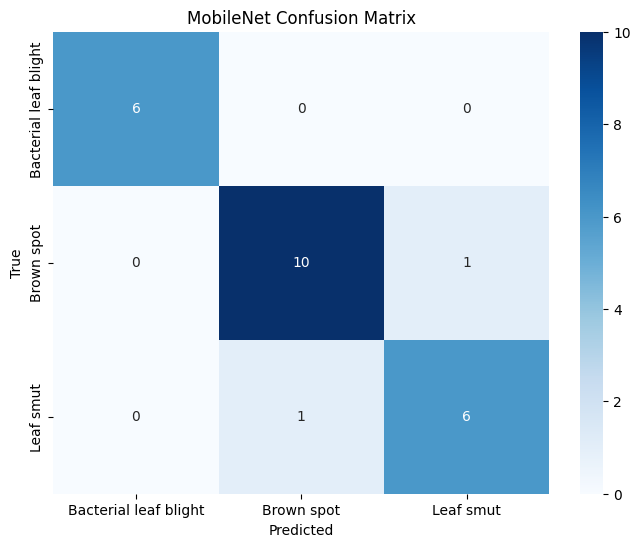

In [ ]:
# Confusion Matrix for MobileNet
cm_mobilenet = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_mobilenet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('MobileNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()